# Predict stock prices using RNNs
~~Based on Lilan Weng's [blog post](https://lilianweng.github.io/lil-log/2017/07/08/predict-stock-prices-using-RNN-part-1.html)~~
* ~~[*her code*](https://github.com/lilianweng/stock-rnn)~~

~~Now following [this](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/) tutorial~~

~~Actually [this](https://www.youtube.com/watch?v=arydWPLDnEc) one~~

Actually [this](https://towardsdatascience.com/lstm-for-google-stock-price-prediction-e35f5cc84165) one

### Variables
* ${W_i}$: Window i
* ${w}$: size of windows 
* ${p_i}$: stock price at end of day i


**Predict:** ${W_{t+1}}$
* where ${W_{t+1}} = (p_{(t+1)w}, p_{(t+1)w+1}, ..., p_{(t+2)w-1})$
* and ${W_{t}} = (p_{tw}, p_{tw+1}, ..., p_{(t+1)w-1})$

i.e., we learn a function $f(W_0, ..., W_t) \approx W_{t+1}$

**RNN:**
![](imgs/unrolled_RNN.png)

* `input_size`: number of timesteps (days) in a window
* `num_steps`: number of windows in a single training ex 

## 1 - Fetching and formatting the data
### 1.1 - Fetching
The [pandas](https://pandas.pydata.org/pandas-docs/version/0.15/tutorials.html) library is used for data access / manipulation

In [1]:
import click
import os
import pandas as pd
import random
import time
import urllib
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

#from BeautifulSoup import BeautifulSoup
from datetime import datetime

#np.version.version
#print(tf.__version__)

In [2]:
def get_csv():
    df = pd.read_csv("../data/_SP500.csv")
    #df['Close'].plot().set_ylabel("Stock price ($)")
    return df
    #return df['Date','Open'].iloc[:, 1: 2]

In [3]:
df = get_csv()
raw_np = df['Open'].to_numpy().reshape(-1, 1)
print(raw_np.shape)
#train_set

print(raw_np[0:10])

(16979, 1)
[[16.66    ]
 [16.85    ]
 [16.93    ]
 [16.98    ]
 [17.09    ]
 [17.030001]
 [17.09    ]
 [16.76    ]
 [16.67    ]
 [16.65    ]]


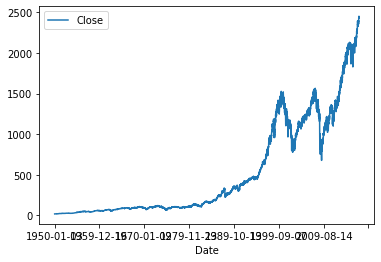

In [4]:
df.plot(x='Date', y='Close')
#df.plot(x='Date', y='Close').get_figure().savefig('filename.png', dpi=300)

### 1.2 - Formatting: normalizing data

The RNN has trouble predicting growth with raw numbers.
![](https://lilianweng.github.io/lil-log/assets/images/a_sad_example_stock_prediction.png)
Therefore, we normalize the data within a given widnow so that the RNN will be predicting  change relative to the final value in the previous sliding window, rather than future absolute values.
$$
W'_t = (\frac{p_{tw}}{p_{tw-1}}, \frac{p_{tw+1}}{p_{tw-1}}, \dots, \frac{p_{(t+1)w-1}}{p_{tw-1}})
$$

In [5]:
def normalize_data(arr, input_size):
    for i in range(arr.shape[0]):
        
        # If 1st window, we measure change w.r.t. 1st close price
        # otherwise, follow rule explained above
        if i == 0:
            prev_close_price = arr[i,0]
        else: 
            prev_close_price = arr[i-1, input_size-1]
            
        arr[i] = np.divide(arr[i], prev_close_price)
        
    return arr

### 1.3 - Formatting: splittling data and grouping them into training examples
#### Splitting data into discrete windows:
<img src="../imgs/graph_just_windows.png" style="width:60%;height:60%;">

- $|W_i| = |y_j| = w = $ `input_size` $ = 1$ by default
- $|X_j| =$ `num_steps` $ = 30$ by default
 
 <br/>
 
#### Grouping into training examples

Each training example $X_j$ contains `num_steps` windows, and has an associated *label window* $y_j$ immediately following:
<img src="../imgs/graph_single_window.png" style="width:60%;height:60%;">

Each training example $X_j$ is followed by a training example $X_{j+1}$ which is another group of `num_steps` windows, shifted over by 1 window:

<img src="../imgs/graph_training_exs.png" style="width:60%;height:60%;">

Mathematically, these training examples can be represented like this:

$$
X_1 = [[p_0, p_1, p_2], [p_3, p_4, p_5]], y_1 = [p_6, p_7, p_8] \\
X_2 = [[p_3, p_4, p_5], [p_6, p_7, p_8]], y_2 = [p_9, p_{10}, p_{11}] \\
X_3 = [[p_6, p_7, p_8], [p_9, p_{10}, p_{11}]], y_3 = [p_{12}, p_{13}, p_{14}]
$$

In [6]:
def split_data(arr, input_size, num_steps):
        # split the data into discrete windows of size `input_size`
        windows = np.array([arr[i * input_size : (i+1) * input_size]
              for i in range(arr.shape[0] // input_size)])
        
        # (i, j, 1) -> (i, j)
        windows = windows.reshape(windows.shape[0:2])
        
        windows = normalize_data(windows, input_size)
        
        
        # Group the windows into training examples of `num_steps` windows.
        X = np.array([np.array( windows[j : j + num_steps] )
              for j in range( windows.shape[0] - num_steps )])
        
        y = np.array([np.array(windows[j + num_steps])
              for j in range(windows.shape[0] - num_steps)])
        
        #return (X.reshape(X.shape[:3]), y.reshape(y.shape[:2]))
        return (X, y)
        

In [7]:
#print(raw_np)
input_size = 5
num_steps = 3

#windows = split_data(raw_np, input_size, num_steps)
#windows.shape

X, y = split_data(raw_np, input_size, num_steps)

print("X shape: " + str(X.shape))
print("y shape: " + str(y.shape))

# print(X[-1])
# print(y[-2])
# print(str(X[1, 0]) + '\n')
# print(str(y[0]))

X shape: (3392, 3, 5)
y shape: (3392, 5)


## 2 - Model construction
### 2.1 - Defining hyperparameters
We put all the hyperparameters in 1 object for easy access.

In [15]:
class RNNConfig():
    input_size = 1
    num_steps = 60  # lilog: 30
    lstm_size = 50  # lilog: 128
    num_layers = 1
    drop_prob = 0.2 # lilog: keep_prob=0.8
    batch_size = 64
    init_learning_rate = 0.001
    learning_rate_decay = 0.99
    init_epoch = 5
    max_epoch = 50

config = RNNConfig()

### 2.2 - Model definition
The last 10% of the data will be taken as training data.

In [30]:
def model(config):
    # get data from CSV
    df = get_csv()
    raw_np = df['Open'].to_numpy().reshape(-1, 1)
    
    X, y = split_data(raw_np, config.input_size, config.num_steps)
    print("X shape: " + str(X.shape))
    print("y shape: " + str(y.shape))
    
    X_train, X_test = X[ :int(.9*X.shape[0]) ], X[ int(.9*X.shape[0]): ]
    y_train, y_test = y[ :int(.9*y.shape[0]) ], y[ int(.9*y.shape[0]): ]
    
    print("X_train shape: " + str(X_train.shape) + "\tX_test shape: " + str(X_test.shape))
    print("y_train shape: " + str(y_train.shape) + " \ty_test shape: " + str(y_test.shape))
    
    # assemble the model
    # TODO: Going basically with TDS's topology
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM( units = config.lstm_size, return_sequences = True, input_shape = X_train.shape[1:] ))
    model.add(tf.keras.layers.Dropout(rate = config.drop_prob))
    ##add 2nd lstm layer
    model.add(tf.keras.layers.LSTM(units = config.lstm_size, return_sequences = True))
    model.add(tf.keras.layers.Dropout(rate = config.drop_prob))
    ##add 3rd lstm layer
    model.add(tf.keras.layers.LSTM(units = config.lstm_size, return_sequences = True))
    model.add(tf.keras.layers.Dropout(rate = config.drop_prob))
    ##add 4th lstm layer
    model.add(tf.keras.layers.LSTM(units = config.lstm_size, return_sequences = False))
    model.add(tf.keras.layers.Dropout(rate = config.drop_prob))
    ## Final dense layer of size y[j].shape (== input_size)
    model.add(tf.keras.layers.Dense(config.input_size))
    print(model.summary())
    return (model, X_train, X_test, y_train, y_test)

In [31]:
# TODO: the Xs and Ys should be separate from the model() function
rnn_model, X_train, X_test, y_train, y_test = model(config)

X shape: (16919, 60, 1)
y shape: (16919, 1)
X_train shape: (15227, 60, 1)	X_test shape: (1692, 60, 1)
y_train shape: (15227, 1) 	y_test shape: (1692, 1)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
dropout_17 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_19 (Dropout)         (Non

In [33]:
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

In [37]:
rnn_model.load_weights('../model_save/weights')
rnn_model.fit(x=X_train, y=y_train, batch_size=config.batch_size, epochs=100)
rnn_model.save_weights('../model_save/weights')

Train on 15227 samples
Epoch 1/100
15227/15227 [==============================] - 23s 2ms/sample - loss: 12.2551
Epoch 2/100
15227/15227 [==============================] - 28s 2ms/sample - loss: 12.1358
Epoch 3/100
15227/15227 [==============================] - 28s 2ms/sample - loss: 11.8600
Epoch 4/100
15227/15227 [==============================] - 28s 2ms/sample - loss: 11.3817
Epoch 5/100
15227/15227 [==============================] - 26s 2ms/sample - loss: 11.7320
Epoch 6/100
15227/15227 [==============================] - 25s 2ms/sample - loss: 11.5364
Epoch 7/100
15227/15227 [==============================] - 24s 2ms/sample - loss: 11.6128
Epoch 8/100
15227/15227 [==============================] - 24s 2ms/sample - loss: 12.0610
Epoch 9/100
15227/15227 [==============================] - 24s 2ms/sample - loss: 11.5033
Epoch 10/100
15227/15227 [==============================] - 24s 2ms/sample - loss: 11.9103
Epoch 11/100
15227/15227 [==============================] - 25s 2ms/sample -

15227/15227 [==============================] - 25s 2ms/sample - loss: 9.4242
Epoch 92/100
15227/15227 [==============================] - 25s 2ms/sample - loss: 9.8024
Epoch 93/100
15227/15227 [==============================] - 27s 2ms/sample - loss: 9.6381
Epoch 94/100
15227/15227 [==============================] - 29s 2ms/sample - loss: 10.0894
Epoch 95/100
15227/15227 [==============================] - 26s 2ms/sample - loss: 9.7977
Epoch 96/100
15227/15227 [==============================] - 30s 2ms/sample - loss: 9.9231
Epoch 97/100
15227/15227 [==============================] - 29s 2ms/sample - loss: 9.8055
Epoch 98/100
15227/15227 [==============================] - 31s 2ms/sample - loss: 9.9500
Epoch 99/100
15227/15227 [==============================] - 28s 2ms/sample - loss: 10.0441
Epoch 100/100
15227/15227 [==============================] - 29s 2ms/sample - loss: 10.0460


In [38]:
predicted_stock_price = rnn_model.predict(X_test)

In [60]:
# TODO: how to un-normalize?
#predicted_stock_price
# print(y_train.reshape(y_train.shape[0]).shape, y_test.reshape(y_test.shape[0]).shape)
print(y_train.shape, y_test.shape)
y = np.concatenate( [y_train, y_test] )
print(y.shape)
type(predicted_stock_price)
print(predicted_stock_price.shape)

(15227, 1) (1692, 1)
(16919, 1)
(1692, 1)


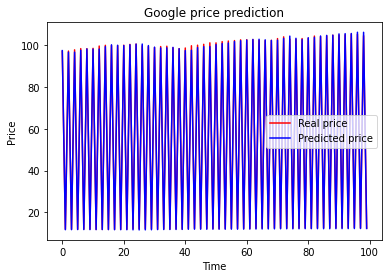

In [65]:
import matplotlib.pyplot as plt
plt.plot(y_test[:100], color = 'red', label = 'Real price')
plt.plot(predicted_stock_price[:100], color = 'blue', label = 'Predicted price')
plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
# TODO: something went so wrong